In [1]:
import cv2
import matplotlib.pyplot as plt
from google.colab import files
from IPython.display import display
from google.colab.patches import cv2_imshow
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import map_coordinates
from scipy.signal import convolve2d

In [102]:
print("Incarcati o imagine de test")
uploaded_test_image = files.upload()  # Allows user to upload a file
# Get the first uploaded file
uploaded_test_image_path = list(uploaded_test_image.keys())[0]

Incarcati o imagine de test


Saving S1245R02.jpg to S1245R02.jpg


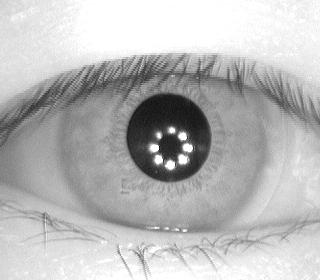

Original eye image


In [103]:
img = cv2.imread(uploaded_test_image_path, cv2.IMREAD_GRAYSCALE)
cv2_imshow(img)
print("Original eye image")

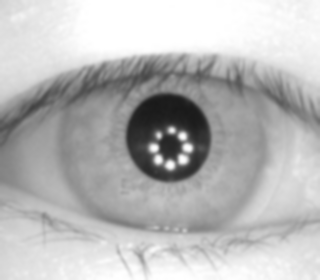

In [104]:
blurred = cv2.GaussianBlur(img, (7, 7), 0)
cv2_imshow(blurred)

## Aplicam detectia muchiilor

Folosim metoda Canny care ofera o imagine cu mai putin zgomot

În metoda de detecție a marginilor Canny, procesul de detectare se bazează pe calculul gradientului imaginii, care reflectă schimbările de intensitate la nivelul pixelilor. Gradientul măsoară viteza cu care se schimbă luminozitatea unui pixel față de cei din jurul său, iar marginile sunt acele zone unde schimbările de intensitate sunt mari. Algoritmul Canny folosește două praguri pentru a diferenția marginile clare de cele mai puțin evidente.

Primul parametru, pragul inferior, se referă la valoarea minimă a gradientului care este considerată o margine posibilă. Pixeii care au valori ale gradientului mai mici decât acest prag sunt respinși și nu sunt considerați margini, indiferent de conexiunile lor cu alți pixeli. Al doilea parametru, pragul superior, stabilește valoarea maximă a gradientului pentru care un pixel este considerat o margine certă. Pixeii cu valori mai mari decât acest prag sunt direct considerați margini clare. Cei cu valori între cele două praguri vor fi considerați margini doar dacă sunt conectați la pixeii care au valori mai mari decât pragul superior. Acest sistem permite algoritmului să fie mai precis, diferențiind marginile puternice de cele mai subtile.










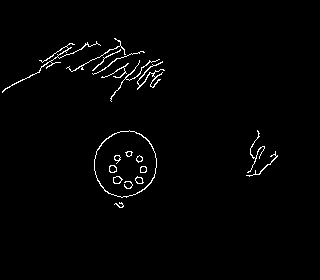

In [71]:
edges = cv2.Canny(blurred, 50, 200)
cv2_imshow(edges)

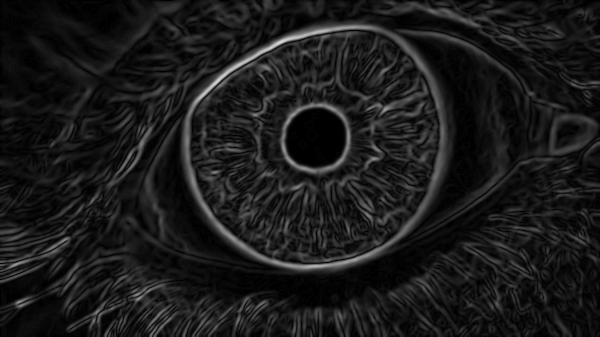

In [42]:
sobel_x = cv2.Sobel(blurred, cv2.CV_64F, 1, 0, ksize=3)
sobel_y = cv2.Sobel(blurred, cv2.CV_64F, 0, 1, ksize=3)
sobel_edges = cv2.magnitude(sobel_x, sobel_y)
sobel_edges = cv2.convertScaleAbs(sobel_edges)
cv2_imshow(sobel_edges)

**blurred**: Imaginea de intrare care a fost aplicată unui filtru de estompare (de obicei, folosind cv2.GaussianBlur), pentru a reduce zgomotul și a îmbunătăți performanța detectării cercurilor.

**cv2.HOUGH_GRADIENT**: Aceasta este metoda de detecție folosită pentru a aplica transformata Hough la imagine. cv2.HOUGH_GRADIENT este algoritmul clasic bazat pe gradient care este utilizat pentru detectarea cercurilor. Aceasta este metoda cea mai des folosită și oferă rezultate bune pentru imagini cu zgomot redus.

**dp=1.5**: Parametrul dp reprezintă raportul de rezoluție. Acesta este un factor de scalare a imaginii pentru a aplica transformata Hough. Cu cât valoarea este mai mare, cu atât imaginea va fi mai mică la transformarea Hough. Dacă valoarea este setată la 1.5, aceasta înseamnă că dimensiunea imaginii va fi redusă de 1.5 ori în timpul procesării.

**minDist=blurred.shape[0] / 8**: minDist reprezintă distanța minimă permisă între centrele cercurilor detectate. Acest parametru ajută la evitarea detectării a cercurilor foarte apropiate între ele. Valoarea este setată la 1/8 din înălțimea imaginii (blurred.shape[0]), ceea ce asigură o distanță corespunzătoare între cercuri pentru a preveni detectarea de cercuri foarte apropiate.

**param1=100:** param1 este pragul superior folosit de detecția de margini pentru a detecta cercuri (în cazul în care folosim metoda Hough Gradient). Acesta este un prag de sensibilitate pentru detecția marginii și poate influența precizia detecției. Valori mai mari vor face ca doar marginile mai puternice să fie luate în considerare.

**param2=30:** param2 reprezintă pragul pentru detectarea centrului cercului. Este folosit pentru a filtra cercurile candidate și pentru a determina dacă un cerc detectat este valid sau nu. Cu cât valoarea este mai mică, cu atât vor fi detectate mai multe cercuri, inclusiv cele care nu sunt chiar cercuri perfecte.

**minRadius=20:** minRadius este raza minimă acceptată pentru cercuri. Acesta definește dimensiunea minimă a cercurilor care vor fi detectate. Dacă cercurile detectate au un diametru mai mic decât acest parametru, vor fi ignorate.

**maxRadius=80:** maxRadius este raza maximă acceptată pentru cercuri. Acesta definește dimensiunea maximă a cercurilor care vor fi detectate. Dacă cercurile detectate au un diametru mai mare decât acest parametru, vor fi ignorate.

In [110]:
circles = cv2.HoughCircles(
    blurred,
    cv2.HOUGH_GRADIENT,
    dp=1.5,
    minDist=20,
    param1=230,
    param2=40,
    minRadius=20,
    maxRadius=150
)
print(circles)

[[[170.25 135.75  44.15]]]


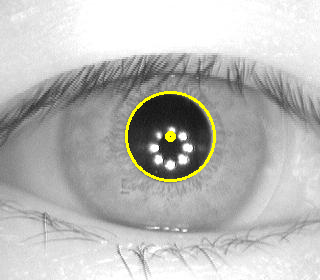

Total circles detected: 1


In [111]:
all_circles = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)

if circles is not None:
    # Convert to integer
    circles = np.uint16(np.around(circles))

    # Draw the circles on the image
    for i in circles[0, :]:
        center = (i[0], i[1])  # Circle center
        radius = i[2]  # Circle radius
        # Draw the center of the circle (small dot)
        cv2.circle(all_circles, center, 3, (0, 255, 255), 3)
        # Draw the perimeter of the circle
        cv2.circle(all_circles, center, radius, (0, 255, 255), 2)

    # Display the result
    cv2_imshow(all_circles)
    print(f"Total circles detected: {len(circles[0])}")
else:
    print("No circles detected.")

In [120]:
if circles is not None:
    circles = np.uint16(np.around(circles))
    pupil_x, pupil_y, pupil_r = circles[0][0]
    sorted_circles = sorted(circles[0], key=lambda x: x[2])  # Sort by radius size
    if len(sorted_circles) > 1:
      iris_x, iris_y, iris_r = sorted_circles[1]
    else:
      iris_x, iris_y, iris_r = sorted_circles[0]
      iris_r = 2 * iris_r  # Double the radius of the iris

else:
    raise Exception("No iris/pupil circle detected.")


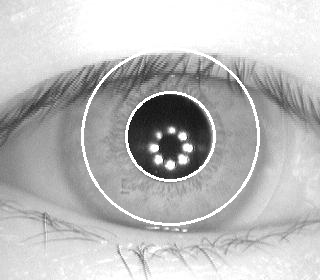

✅ Segmented iris & pupil


In [121]:
circled = img.copy()
cv2.circle(circled, (pupil_x, pupil_y), pupil_r, 255, 2)
cv2.circle(circled, (iris_x, iris_y), iris_r, 255, 2)
cv2_imshow(circled)
print("✅ Segmented iris & pupil")

In [118]:
# def normalize_iris(img, center, r_in, r_out, size=(64, 512)):
#     theta = np.linspace(0, 2 * np.pi, size[1])
#     radius = np.linspace(r_in, r_out, size[0])

#     # Create polar grid
#     x = center[0] + radius[:, None] * np.cos(theta)
#     y = center[1] + radius[:, None] * np.sin(theta)

#     coords = np.array([y.flatten(), x.flatten()])
#     polar = map_coordinates(img, coords, order=1, mode='reflect').reshape(size)
#     return polar.astype(np.uint8)

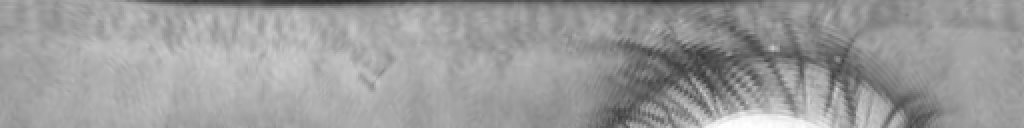

In [123]:
size=(64, 512)
theta = np.linspace(0, 2 * np.pi, size[1])
radius = np.linspace(int(pupil_r), iris_r, size[0])

    # Create polar grid
x = pupil_x + radius[:, None] * np.cos(theta)
y = pupil_y + radius[:, None] * np.sin(theta)

coords = np.array([y.flatten(), x.flatten()])
polar = map_coordinates(img, coords, order=1, mode='reflect').reshape(size)
norm_iris = polar.astype(np.uint8)
norm_iris_upscaled = cv2.resize(norm_iris, None, fx=2.0, fy=2.0, interpolation=cv2.INTER_NEAREST)
cv2_imshow(norm_iris_upscaled)

In [125]:
def gabor_filter(kernel_size=31, sigma=4.0, theta=0, lambd=10.0, gamma=0.5, psi=0):
    """Return a 2D Gabor filter kernel."""
    return cv2.getGaborKernel((kernel_size, kernel_size), sigma, theta, lambd, gamma, psi, ktype=cv2.CV_64F)


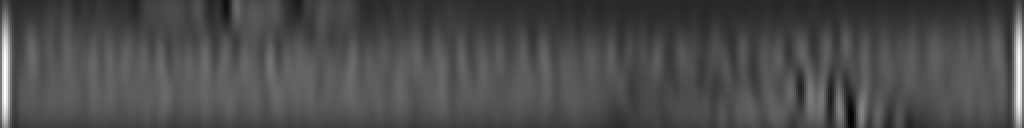

Gabor filter response


In [126]:
gabor = gabor_filter()
features = convolve2d(norm_iris, gabor, mode='same')

# Normalize for display
features_norm = cv2.normalize(features, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
features_upscaled = cv2.resize(features_norm, None, fx=2.0, fy=2.0, interpolation=cv2.INTER_NEAREST)

cv2_imshow(features_upscaled)
print("Gabor filter response")



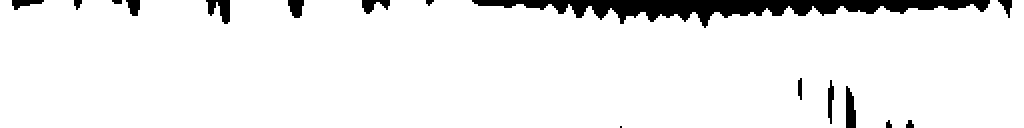

Binary iris code generated


In [133]:
# -- Step 5: Create iris code --
threshold =250
iris_code = (features > threshold).astype(np.uint8) * 255
iris_code_upscaled = cv2.resize(iris_code, None, fx=2.0, fy=2.0, interpolation=cv2.INTER_NEAREST)
cv2_imshow(iris_code_upscaled)
print("Binary iris code generated")

In [134]:
def gabor_kernel(ksize=31, sigma=4.0, theta=0, lambd=10.0, gamma=0.5, psi=0):
    """Returns a complex Gabor kernel (real + imaginary)."""
    y, x = np.meshgrid(
        np.linspace(-1, 1, ksize),
        np.linspace(-1, 1, ksize)
    )
    rotx = x * np.cos(theta) + y * np.sin(theta)
    roty = -x * np.sin(theta) + y * np.cos(theta)
    envelope = np.exp(-(rotx**2 + gamma**2 * roty**2) / (2 * sigma**2))
    carrier = np.exp(1j * (2 * np.pi * rotx / lambd + psi))
    return envelope * carrier

# Assume norm_iris (your normalized polar image) is already defined
gabor = gabor_kernel(ksize=15, sigma=2.5, lambd=8.0, theta=0)

# Convolve with Gabor kernel (complex convolution)
real_response = convolve2d(norm_iris, np.real(gabor), mode='same')
imag_response = convolve2d(norm_iris, np.imag(gabor), mode='same')

# Compute phase
phase = np.arctan2(imag_response, real_response)

# Quantize into 2-bit values (0–3)
# Phase goes from -π to π, we shift to 0–2π and divide
quantized = ((phase + np.pi) / (np.pi / 2)).astype(np.uint8) % 4  # values: 0, 1, 2, 3

# Convert to binary string per pixel
iris_code = np.unpackbits(quantized.astype(np.uint8).reshape(-1, 1), axis=1)[:, -2:]  # take last 2 bits
iris_code = iris_code.reshape(norm_iris.shape[0], norm_iris.shape[1], 2)


In [135]:
import base64

# Step 1: Flatten and convert 2-bit pairs to bytes
# iris_code shape is (H, W, 2)
flat_bits = iris_code.reshape(-1, 2)

# Convert 2 bits per pixel to a single value (0–3)
values_2bit = (flat_bits[:, 0] << 1) | flat_bits[:, 1]

# Pack 4 values (2 bits each) into one byte → 4 pixels per byte
# If not divisible by 4, pad with zeros
if len(values_2bit) % 4 != 0:
    pad_len = 4 - (len(values_2bit) % 4)
    values_2bit = np.pad(values_2bit, (0, pad_len), constant_values=0)

# Now pack
packed_bytes = []
for i in range(0, len(values_2bit), 4):
    byte = (
        (values_2bit[i]   << 6) |
        (values_2bit[i+1] << 4) |
        (values_2bit[i+2] << 2) |
        (values_2bit[i+3])
    )
    packed_bytes.append(byte)

packed_bytes = np.array(packed_bytes, dtype=np.uint8)

# Step 2: Encode to Base64
base64_string = base64.b64encode(packed_bytes.tobytes()).decode('ascii')

print("Base64 Iris Code:\n", base64_string)

Base64 Iris Code:
 VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVaqqqqqqqqqqqlVVVVVVVVVVVVVVVWqqqqqqqqqlVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVaqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV